In [7]:
!pip install tensorflow numpy pandas opencv-python matplotlib scikit-learn kagglehub

In [8]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, GlobalAveragePooling2D,Lambda,BatchNormalization,MaxPooling2D,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

In [9]:
import kagglehub
path = kagglehub.dataset_download("tejasreddy/iam-handwriting-top50")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/iam-handwriting-top50


In [10]:
image_dir = '/kaggle/input/iam-handwriting-top50/data_subset/data_subset'
txt_path = '/kaggle/input/iam-handwriting-top50/forms_for_parsing.txt'

In [11]:
def preprocess_image(image_path, target_size=(128,128)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    return img.astype(np.float32) / 255.0

In [12]:
form_writer_map = {}
with open(txt_path, 'r') as f:
    for line in f:
        if line.strip():
            parts = line.strip().split()
            if len(parts) >= 2:
                form_id, writer_id = parts[0], parts[1]
                form_writer_map[form_id] = writer_id

In [13]:
data, labels = [], []
for fname in tqdm(os.listdir(image_dir)):
    if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        form_id = os.path.splitext(fname)[0].split("-s")[0]
        if form_id in form_writer_map:
            label = form_writer_map[form_id]
            img_path = os.path.join(image_dir, fname)
            img = preprocess_image(img_path)
            data.append(img)
            labels.append(label)
X = np.array(data)
y = np.array(labels)

100%|██████████| 4899/4899 [00:34<00:00, 141.42it/s]


In [14]:
from collections import Counter
label_counts = Counter(labels)
top_writers = [writer for writer, count in label_counts.most_common(10)]
filtered_data = []
filtered_labels = []
for img, label in zip(data, labels):
    if label in top_writers:
        filtered_data.append(img)
        filtered_labels.append(label)

X = np.array(filtered_data)
y = np.array(filtered_labels)

In [15]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

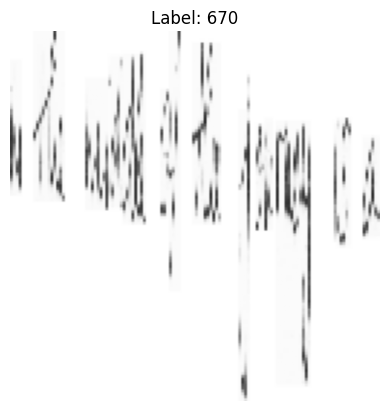

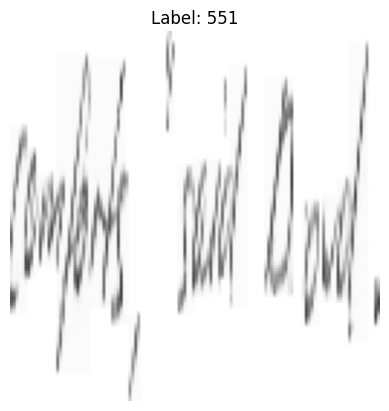

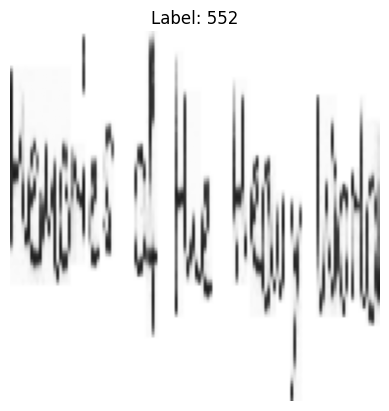

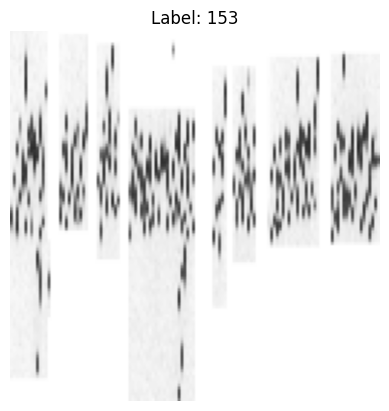

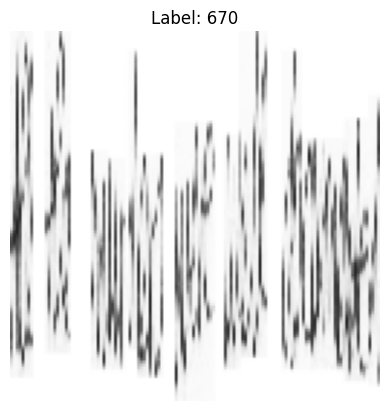

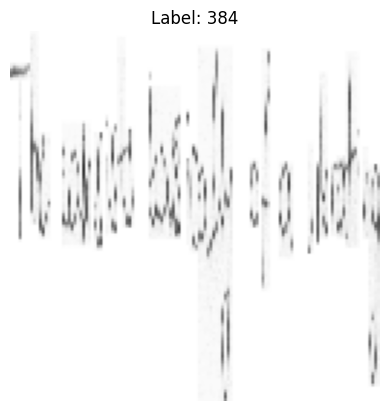

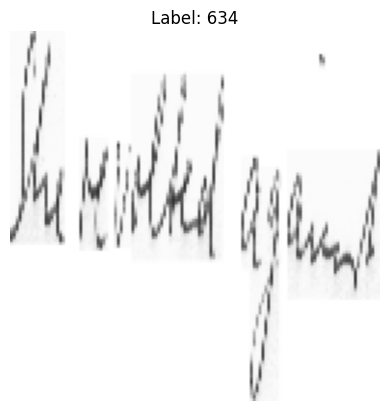

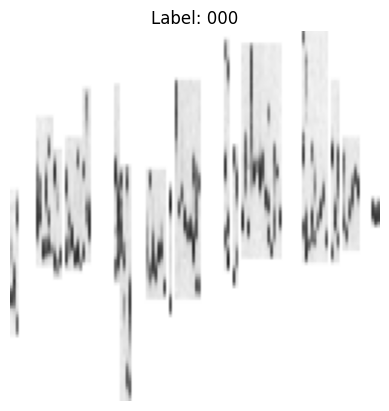

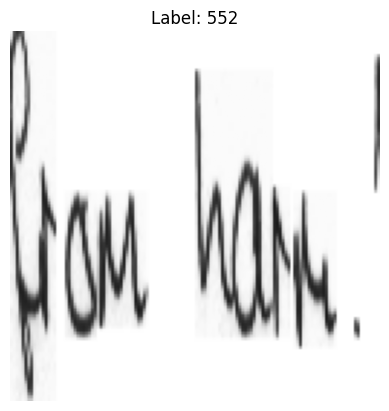

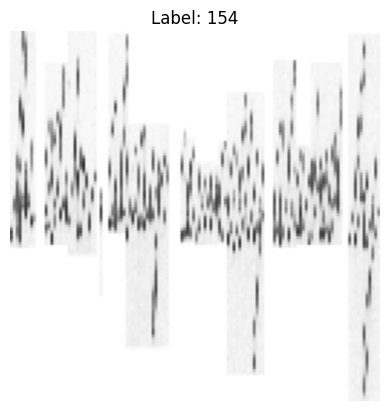

In [17]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    label = le.inverse_transform([np.argmax(y_train[i])])[0]
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()


In [18]:
def contrastive_loss(margin=1.0):
    def loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return loss

In [19]:
def build_base_cnn(input_shape=(128, 128, 1)):
    base_cnn = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_cnn.trainable = False  # Optional: fine-tune later

    x = base_cnn.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    model = Model(inputs=base_cnn.input, outputs=x)
    return model

In [20]:
def build_siamese_model(input_shape=(128, 128, 1)):
    base_cnn = build_base_cnn(input_shape)

    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    encoded_a = base_cnn(input_a)
    encoded_b = base_cnn(input_b)

    # Compute absolute difference
    L1_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_a, encoded_b])

    output = Dense(1, activation='sigmoid')(L1_distance)

    siamese_net = Model(inputs=[input_a, input_b], outputs=output)
    return siamese_net


In [21]:
def create_pairs(images, labels):
    pair_images = []
    pair_labels = []

    # Get the original class labels from one-hot encoded labels
    original_labels = np.argmax(labels, axis=1)

    label_to_indices = {label: np.where(original_labels == label)[0] for label in np.unique(original_labels)}

    for idx in range(len(images)):
        current_image = images[idx]
        current_label = original_labels[idx]  # Use original label

        # Positive pair
        positive_idx = idx
        while positive_idx == idx:
            positive_idx = random.choice(label_to_indices[current_label])
        pair_images.append([current_image, images[positive_idx]])
        pair_labels.append(1)

        # Negative pair
        neg_label = current_label
        while neg_label == current_label:
            neg_label = random.choice(list(label_to_indices.keys()))
        neg_idx = random.choice(label_to_indices[neg_label])
        pair_images.append([current_image, images[neg_idx]])
        pair_labels.append(0)

    return np.array(pair_images), np.array(pair_labels)


In [22]:
train_pairs, train_labels = create_pairs(X_train, y_train)
test_pairs, test_labels = create_pairs(X_test, y_test)

X1_train = train_pairs[:, 0]
X2_train = train_pairs[:, 1]
X1_test = test_pairs[:, 0]
X2_test = test_pairs[:, 1]

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


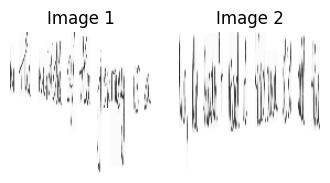

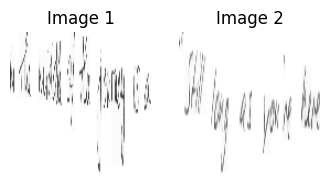

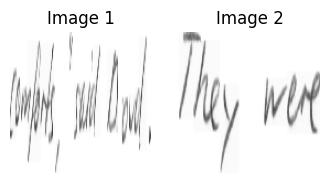

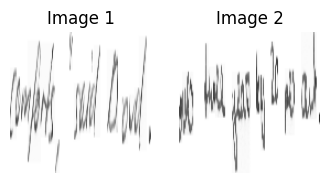

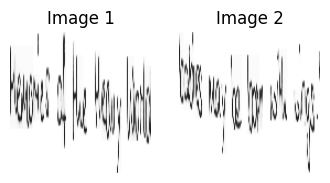

In [26]:
import matplotlib.pyplot as plt

def show_image_pair(img1, img2, label, idx=None):
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.title('Image 1')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap='gray')
    plt.title('Image 2')
    plt.axis('off')

for i in range(5):
    print(y_train[i])
    show_image_pair(X1_train[i], X2_train[i], y_train[i], idx=i)

In [27]:
siamese_model = build_siamese_model(input_shape=(128, 128, 3))
siamese_model.compile(loss=contrastive_loss(1.5), optimizer='adam')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


history = siamese_model.fit(
    [X1_train,X2_train],train_labels,
    validation_data=([X1_test,X2_test],test_labels),
    epochs=10,
    batch_size=16,
    callbacks=[early_stop,reduce_lr]
)

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 45s 134ms/step - loss: 0.5161 - val_loss: 0.4662 - learning_rate: 0.0010
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - loss: 0.4309 - val_loss: 0.4458 - learning_rate: 0.0010
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.3735 - val_loss: 0.4287 - learning_rate: 0.0010
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.3390 - val_loss: 0.4247 - learning_rate: 0.0010
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.3008 - val_loss: 0.4116 - learning_rate: 0.0010
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.2761 - val_loss: 0.4240 - learning_rate: 0.0010
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 0.2549 - val_loss: 0.4234 - learning_rate: 0.0010
Epoch 8/10
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2346
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.2347 - val_loss: 0.4173

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Test Accuracy: 76.1838%
Confusion Matrix:
[[259 100]
 [ 71 288]]
Pair 1: Predicted = Same Writer, Actual = Same Writer
Pair 2: Predicted = Different Writer, Actual = Different Writer
Pair 3: Predicted = Same Writer, Actual = Same Writer
Pair 4: Predicted = Same Writer, Actual = Different Writer
Pair 5: Predicted = Same Writer, Actual = Same Writer
Pair 6: Predicted = Different Writer, Actual = Different Writer
Pair 7: Predicted = Same Writer, Actual = Same Writer
Pair 8: Predicted = Same Writer, Actual = Different Writer
Pair 9: Predicted = Same Writer, Actual = Same Writer
Pair 10: Predicted = Different Writer, Actual = Different Writer


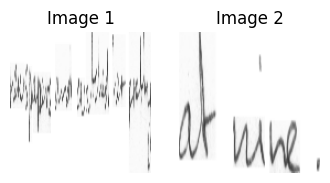

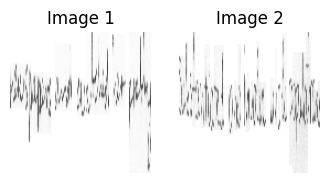

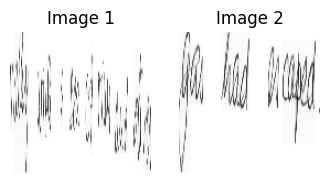

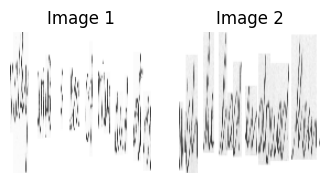

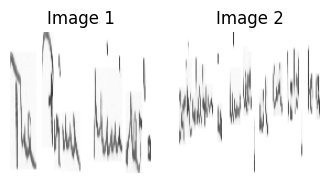

In [34]:
pred_distances = siamese_model.predict([X1_test, X2_test])

threshold = 0.8
pred_labels = (pred_distances < threshold).astype(int).flatten()

from sklearn.metrics import accuracy_score, confusion_matrix

acc = accuracy_score(test_labels, pred_labels)
cm = confusion_matrix(test_labels, pred_labels)

print(f"Test Accuracy: {acc*100:.4f}%")
print("Confusion Matrix:")
print(cm)

for i in range(10):  # Show first 10 predictions
    pred = pred_labels[i]
    actual = int(test_labels[i])
    print(f"Pair {i+1}: Predicted = {'Same Writer' if pred == 1 else 'Different Writer'}, "
          f"Actual = {'Same Writer' if actual == 1 else 'Different Writer'}")

for i in range(5):
    show_image_pair(X1_test[i], X2_test[i], pred_labels[i], idx=i)

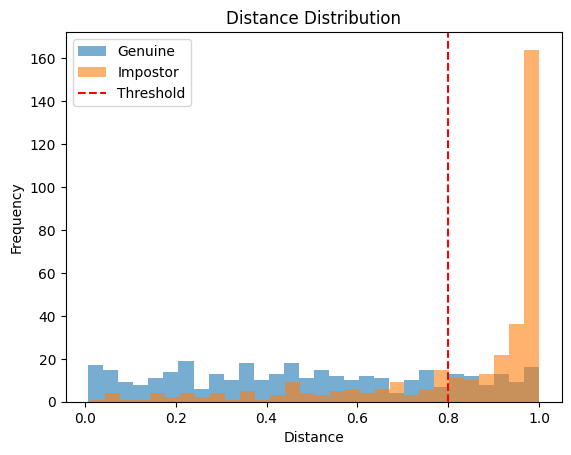

In [31]:
import matplotlib.pyplot as plt

plt.hist(pred_distances[test_labels == 1], bins=30, alpha=0.6, label="Genuine")
plt.hist(pred_distances[test_labels == 0], bins=30, alpha=0.6, label="Impostor")
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.title("Distance Distribution")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()
